In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from utils.folder import ImageFolder
from utils.common_utils import *
import visdom
import numpy as np

vis = visdom.Visdom()

plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
#         transforms.Grayscale(num_output_channels=3),
#         transforms.Resize(400),
        transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0, 0, 0, 0.5], [1, 1, 1, 0.5])
    ]),
    'val': transforms.Compose([
#         transforms.Grayscale(num_output_channels=3),
#         transforms.Resize(400),
        transforms.RandomResizedCrop(224),
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0, 0, 0, 0.5], [1, 1, 1, 0.5])
    ]),
}

data_dir = 'data'
image_datasets = {x: ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=1)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [3]:
use_gpu

True

In [4]:
dataset_sizes

{'train': 48, 'val': 16}

In [5]:
# def pil_loader(path):
#     # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
#     with open(path, 'rb') as f:
#         img = Image.open(f)
#         return img.convert('RGB')

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



1.0
0.003921628


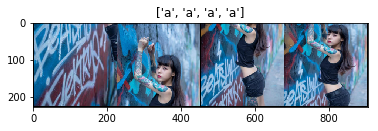

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
_inputs, classes = next(iter(dataloaders['train']))
# print("_inputs.shape=",_inputs.shape)
# Make a grid from batch
inputs = _inputs[:,0:3,:,:]
alphas = _inputs[:,3:4,:,:]
# print(alphas)
print(np.max(alphas.numpy()))
print(np.min(alphas.numpy()))
# print("inputs.shape=",inputs.shape)
out = torchvision.utils.make_grid(inputs)
# print(out.shape)
imshow(out, title=[class_names[x] for x in classes])

In [7]:
# vis.image(out,win='in')

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [8]:
def RGBAShow(rgb_np,a_np1=None,a_np2=None,phase = ''):
    vis.image(rgb_np,win = phase+'rgb',opts=dict(title=phase+'rgb'))
    if a_np1 is not None:
        #out_np1 = np.concatenate((rgb_np,a_np1),axis=0)
        out_np1 = rgb_np*a_np1
#         vis.image(out_np1,win = phase+'a1',opts=dict(title=phase+'a1'))
        vis.image(a_np1*255,win = phase+'a1_mask',opts=dict(title=phase+'a1_mask'))
    if a_np2 is not None:
        #out_np2 = np.concatenate((rgb_np,a_np2),axis=0)
        out_np2 = rgb_np*a_np2
#         vis.image(out_np2,win = phase+'a2',opts=dict(title=phase+'a2'))
        vis.image(a_np2*255,win = phase+'a2_mask',opts=dict(title=phase+'a2_mask'))
        

In [9]:
def plotLosses():
    plt.plot(all_losses['train'],label='train')
    plt.plot(all_losses['val'],label='val')
    plt.legend()


In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 0.0
    all_losses={'train':[],'val':[]}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            
            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs ,labels没有用，只是必须有这层结构
                _inputs, labels = data
                #把alpha通道拆出来，作为label,剩下的作为rgb3通道input
#                 print('_inputs.shape=',_inputs.shape)
                inputs = _inputs[:,0:3,:,:]
                labels = _inputs[:,3:4,:,:]
#                 labels = (labels-0.5)*2
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                #print('========= outputs===================',outputs[0])
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data.item() * inputs.size(0)
                #show sample
                RGBAShow(inputs.cpu().detach().numpy()[0], a_np1= labels.cpu().detach().numpy()[0], a_np2 = outputs.cpu().detach().numpy()[0],phase = phase)

            epoch_loss = running_loss / dataset_sizes[phase]
            all_losses[phase].append(epoch_loss)
            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'train' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())


            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,all_losses

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [11]:
from models.skip import skip
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'
reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01
OPTIMIZER='adam' # 'LBFGS'
show_every = 500
num_iter=2400
input_depth = 3
figsize = 5 
dtype = (torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)

net = skip(
            input_depth, 1, 
            num_channels_down = [8, 16, 32, 64, 128, ], 
            num_channels_up   = [8, 16, 32, 64, 128,],
            num_channels_skip = [4, 4, 4, 4, 4,], 
            upsample_mode='bilinear',
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

net = net.type(dtype)
# print(net)

In [12]:
# for param in net.parameters():
#     print(type(param.data), param.size())
#     print(param.data)

# s = sum([np.prod(list(p.size())) for p in net.parameters() ])
# print(s)

In [13]:
# weights initializing is far important than you imaging
# learn from inpainting
for n in [x for x in net.parameters()]:
    n.data.normal_()

In [14]:
model_ft = net

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.MSELoss().type(dtype)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [15]:
model_ft,all_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=55)

Epoch 0/54
----------


/home/yuan/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


train Loss: 0.4118
val Loss: 0.2455
Epoch 1/54
----------
train Loss: 0.4081
val Loss: 0.3665
Epoch 2/54
----------
train Loss: 0.3751
val Loss: 0.3990
Epoch 3/54
----------
train Loss: 0.3920
val Loss: 0.3910
Epoch 4/54
----------
train Loss: 0.3800
val Loss: 0.3763
Epoch 5/54
----------
train Loss: 0.3748
val Loss: 0.3890
Epoch 6/54
----------
train Loss: 0.3664
val Loss: 0.3885
Epoch 7/54
----------
train Loss: 0.3722
val Loss: 0.3676
Epoch 8/54
----------
train Loss: 0.3735
val Loss: 0.3772
Epoch 9/54
----------
train Loss: 0.3705
val Loss: 0.3681
Epoch 10/54
----------
train Loss: 0.3735
val Loss: 0.3571
Epoch 11/54
----------
train Loss: 0.3648
val Loss: 0.3359
Epoch 12/54
----------
train Loss: 0.3738
val Loss: 0.3525
Epoch 13/54
----------
train Loss: 0.3637
val Loss: 0.3354
Epoch 14/54
----------
train Loss: 0.3767
val Loss: 0.3775
Epoch 15/54
----------
train Loss: 0.3707
val Loss: 0.3452
Epoch 16/54
----------
train Loss: 0.3697
val Loss: 0.3677
Epoch 17/54
----------
train 

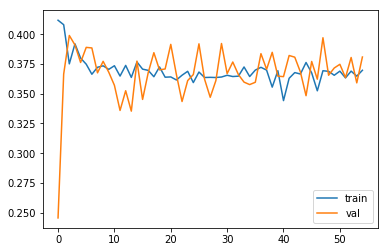

In [16]:
plotLosses()

In [ ]:
# Show a picture 

# Get a batch of training data
_inputs, classes = next(iter(dataloaders['train']))
print("_inputs.shape=",_inputs.shape)
# Make a grid from batch
inputs = _inputs[:,0:3,:,:]

# print(inputs[0])
inputs_a = _inputs[:,3:4,:,:]
if use_gpu:
    inputs = Variable(inputs.cuda())

model_ft.train(False)    
outs = model_ft(inputs)

# print(outs.cpu()[0])

In [ ]:
rgb_batch = inputs.cpu().detach().numpy()
np_to_pil(rgb_batch[0]).save('rgb.jpg')

a2_batch = outs.cpu().detach().numpy()
a1_batch = inputs_a.cpu().detach().numpy()
rgba_batch = np.concatenate((rgb_batch,a2_batch),axis=1)

rgba_np=rgba_batch[0]
rgba_pil = np_to_pil(rgba_np)
rgba_pil.show()
rgba_pil.save('rgba.png')



In [60]:
RGBAShow(rgb_batch[0],a_np1=a1_batch[0],a_np2=a2_batch[0])


NameError: name 'rgb_batch' is not defined

In [61]:
# def RGBAShowBatch(rgb_np,a_np):
#     out_np = np.concatenate((rgb_np,a_np),axis=1)
#     vis.images(out_np,win='out',opts=dict(caption='out list'),)

# RGBAShowBatch(rgb_batch,a_batch)

In [62]:
np.min(a2_batch)

NameError: name 'a2_batch' is not defined

In [25]:
np_to_pil(inputs.cpu().detach().numpy()[0]).save('input.jpg')

In [26]:

_inputs, classes = next(iter(dataloaders['train']))
ii = _inputs.cpu().detach().numpy()[0]
print(ii.shape)
# print(ii[0])
# print(ii[1])
# print(ii[2])


def dumpnp(a):
    for h in range(a.shape[0]):
        print('[{0}]'.format(h),end='')
        for i in range (a.shape[1]):
            print('[{0}][{1}]'.format(h,i),end='')
            for j in range(a.shape[2]):
                print(a[h][i][j],',',end='')
            print("")
        print("")
def dumpnp2(a):
    for i in range (a.shape[1]):
        print('[{0}]'.format(i),end='')
        for j in range(a.shape[2]):
            print(a[0][i][j]+a[1][i][j]+a[2][i][j],',',end='')
        print("")
    print("")
                
dumpnp2(ii)

(4, 224, 224)
[0]0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.6156863 ,0.6431373 ,0.75686276 ,1.0196079 ,1.2823529 ,1.1450981 ,0.75686276 ,0.6666667 ,0.69803923 ,0.654902 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.99215686 ,1.1529412 ,1.0431373 ,0.9529412 ,1.1333334 ,1.0980393 ,1.0196079 ,1.0 ,1.0078431 ,1.054902 ,1.0980393 ,1.1803921 ,1.1764706 ,1.0509804 ,0.854902 ,0.83921576 ,0.9725491 ,1.027451 ,1.0078431 ,0.7882353 ,0.9490197 ,1.1411765 ,1.0901961 ,1.054902 ,1.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,2.0 ,2.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,2.0 ,1.3058825 ,1.2627451 ,1.1333333 ,0.96470594 ,0.7372549 ,0.5882353 ,0.8 ,1.2862746 ,1.4039216 ,1.4039216 ,1.3960785 ,1.345098 ,1.4392157 ,1.4941177 ,1.2862746 ,1.4705882 ,1.6588235 ,1.9490197 ,1.7450981 ,2.101961 ,2.5647058 ,2.4313726 ,1.9372549 ,1.9882354 ,2.4117646 ,2.1803923 ,1.827451 ,1.6705883 ,1.7137256 ,1.7568629 ,1.2627451 ,0.7176471 ,0.69803923 ,0.7490196 ,0.6784314 ,0.56078434 ,0.7254902 ,0.85882354 ,0.90588236 ,0.92941177 ,1.078431

[4]0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.43137258 ,0.44705886 ,0.44705886 ,0.5294118 ,0.6745098 ,0.86274517 ,0.92156863 ,0.83137256 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.1647059 ,1.2235295 ,1.137255 ,1.0431373 ,1.0235294 ,1.0196079 ,0.96862745 ,0.99215686 ,1.0588236 ,1.0901961 ,1.1215687 ,1.1803923 ,1.1921569 ,1.117647 ,0.94509804 ,0.8666667 ,0.90196085 ,0.75686276 ,0.44705886 ,0.5529412 ,0.73333335 ,0.9333334 ,0.94509804 ,1.0 ,1.0 ,1.0 ,1.0 ,2.0 ,2.0 ,1.0 ,1.0 ,2.0 ,2.0 ,2.0 ,2.0 ,1.0 ,1.0 ,2.0 ,2.0 ,0.99215686 ,0.90196085 ,0.69803923 ,0.5137255 ,0.47450984 ,0.8745098 ,1.2980392 ,1.3921568 ,1.372549 ,1.2666667 ,1.4588236 ,1.3686275 ,1.3254902 ,1.5686276 ,2.1333334 ,2.1568627 ,1.9529412 ,2.2156863 ,2.2705882 ,2.2980392 ,2.3411765 ,2.254902 ,2.164706 ,2.172549 ,2.2901962 ,2.4627452 ,2.1960785 ,1.9764707 ,1.1960784 ,0.6431373 ,0.654902 ,0.69803923 ,0.70980394 ,0.7490196 ,0.7882353 ,0.7450981 ,0.77254903 ,0.8705883 ,1.0745099 ,1.2392157 ,1.33333

[14]0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.6509804 ,0.64705884 ,0.7411765 ,0.8666667 ,0.7882353 ,0.6862745 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.4745098 ,1.4078432 ,1.309804 ,1.117647 ,1.0117648 ,1.0039216 ,0.9764706 ,0.9803922 ,0.98823535 ,0.93333334 ,0.96862745 ,0.9803922 ,1.0 ,0.92549026 ,0.8666667 ,0.0 ,1.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,1.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.39215687 ,0.4784314 ,1.0470588 ,1.2392157 ,1.164706 ,1.2745098 ,1.6980393 ,1.9450982 ,2.1450982 ,2.2627451 ,2.3882353 ,2.4431372 ,2.4941177 ,2.5529413 ,2.4901962 ,2.0470588 ,1.682353 ,1.8117647 ,2.2666667 ,2.427451 ,2.1882353 ,1.8705883 ,1.9411765 ,1.8117647 ,1.3764707 ,1.3137255 ,1.3843138 ,1.3843138 ,1.4392157 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,1.3294117 ,1.3490196 ,1.372549 ,1.4745098 ,1.5647058 ,1.4901961 ,1.2784314 ,1.2823529 ,1.4509804 ,1.4901961 ,1.2980392 ,1.1254902 ,1.1411765 ,1.117647 ,1.05

[20]0.5411765 ,0.57254905 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.56078434 ,0.5294118 ,0.52156866 ,0.5411765 ,0.5529412 ,0.86274517 ,1.1058824 ,1.0941176 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.3647059 ,1.2705883 ,1.1647059 ,0.92941177 ,0.854902 ,0.88235295 ,0.0 ,0.0 ,0.0 ,1.0 ,1.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.3686275 ,0.45490196 ,0.9764706 ,1.0745099 ,1.2745098 ,1.4470589 ,1.4862745 ,1.4980392 ,1.5725491 ,1.7882353 ,1.7882354 ,1.5607843 ,1.5176471 ,1.4941177 ,1.5019608 ,1.5450981 ,1.5647058 ,1.5215688 ,1.5058824 ,1.6588237 ,1.6666667 ,1.819608 ,2.062745 ,2.227451 ,2.4509804 ,2.3882353 ,2.2588234 ,2.3529413 ,2.3607843 ,2.301961 ,2.1647058 ,2.2196078 ,2.101961 ,1.8078432 ,1.5294118 ,1.2901962 ,1.1058824 ,1.172549 ,1.3882353 ,1.517647 ,1.5647058 ,1.654902 ,1.690196 ,1.7215686 ,1.772549 ,1.7607844 ,1.690196 ,1.749019

[25]0.15686275 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,1.0 ,1.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,1.0 ,0.8 ,1.0352942 ,1.1137255 ,1.2705883 ,1.4627452 ,1.5215687 ,1.1960784 ,1.0980393 ,1.027451 ,1.0156863 ,1.0901961 ,1.2235295 ,1.4352942 ,1.5450981 ,1.5019608 ,1.4352942 ,1.7450981 ,1.7803922 ,1.7137256 ,1.972549 ,1.8000001 ,1.7607844 ,2.0784316 ,2.1921568 ,2.0745099 ,1.9607844 ,2.0509806 ,2.1137257 ,2.1764708 ,2.4392157 ,2.3803923 ,2.3764706 ,2.2 ,2.2588236 ,2.1176472 ,1.7686275 ,1.5725491 ,1.5843138 ,1.3568628 ,1.1019609 ,1.0862745 ,1.0745099 ,1.0941176 ,1.3137255 ,1.5647058 ,1.7647059 ,1.8784313 ,1.9137256 ,1.8039217 ,1.5333333 ,1.3215687 ,1.2745098 ,1.3215686 ,1.3529412 

[31]0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.30588236 ,0.43137258 ,0.6 ,0.8941177 ,1.0235294 ,1.0431373 ,1.027451 ,1.0431373 ,1.0627451 ,1.027451 ,0.0 ,0.0 ,1.054902 ,1.0235294 ,0.9725491 ,0.9607843 ,0.9372549 ,0.8980392 ,0.99215686 ,1.0313725 ,0.99607843 ,0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,1.0392157 ,0.9529412 ,0.85490197 ,0.84313726 ,0.8980392 ,0.8156863 ,0.79607844 ,0.8392157 ,0.8156863 ,0.7254902 ,0.59607846 ,0.49803925 ,0.4509804 ,0.46666667 ,0.7372549 ,0.8666667 ,0.6627451 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,1.4705882 ,1.4470589 ,1.3647059 ,1.2313726 ,1.1960785 ,1.1254902 ,1.027451 ,1.0588236 ,0.9725491 ,0.98823535 ,1.137255 ,1.2313726 ,1.1607844 ,1.2941177 ,1.4705882 ,1.3764706 ,1.5019608 ,1.6784314 ,1.7764707 ,1.8078432 ,1.8588235 ,1.9411765 ,2.027451 ,2.0235295 ,1.9568628 ,2.0862746 ,2.0862746 ,2.0313725 ,1.9568627 ,1.8509804 ,1.9372549 ,

[36]0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.30980393 ,0.47058827 ,0.7254902 ,0.7254902 ,0.6627451 ,0.53333336 ,0.6 ,0.0 ,0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,0.0 ,0.0 ,1.0 ,2.0 ,2.0 ,2.0 ,1.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,0.0 ,0.0 ,0.58431375 ,0.52156866 ,0.59607846 ,0.7137255 ,0.69411767 ,0.7647059 ,0.73333335 ,0.9019608 ,0.8980392 ,0.9098039 ,0.92941177 ,0.92941177 ,0.8901961 ,0.77254903 ,1.3058825 ,1.5372549 ,1.6 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,1.4235294 ,1.2039216 ,0.8705883 ,0.7490196 ,0.90588236 ,0.8980392 ,0.8666667 ,0.9372549 ,1.0627451 ,1.1529412 ,1.2627451 ,1.1607844 ,1.2078432 ,1.1490196 ,1.1568627 ,1.1333333 ,1.2196078 ,1.4078431 ,1.5294118 ,1.5450981 ,1.4862745 ,1.6235294 ,1.7568629 ,1.7372551 ,2.1686275 ,1.9019608 ,2.1411765 ,2.592157 ,2.6431372 ,2.6705883 ,2.6666667 ,2.6666667 ,2.6313725 ,2.3843136 ,1.6588235 ,1.501960

[42]0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,0.0 ,1.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,1.0 ,2.0 ,1.0 ,1.0 ,1.0 ,0.88235295 ,0.69411767 ,0.5294118 ,0.7372549 ,0.9568628 ,0.86274517 ,0.8117647 ,0.8862746 ,0.8941177 ,0.58431375 ,0.59607846 ,0.46274513 ,0.44705886 ,0.627451 ,0.79607844 ,0.88235295 ,0.8901961 ,0.9098039 ,0.94509804 ,0.99215686 ,0.96862745 ,0.9372549 ,0.96862745 ,1.027451 ,1.2039216 ,1.4705882 ,1.5294118 ,1.5921569 ,1.4980392 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.94117653 ,0.9725491 ,1.0078431 ,1.0901961 ,1.2392157 ,1.2941177 ,1.337255 ,1.4313725 ,1.5333334 ,1.6039217 ,1.6784315 ,1.6588236 ,1.7294118 ,1.8980393 ,1.9803922 ,2.0509806 ,2.101961 ,2.129412 ,2.1568627 ,2.164706 ,2.1490197 ,1.9568629 ,1.4039216 ,1.1019609 ,1.1254902 ,1.2235295 ,1.2

[48]0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.49411765 ,0.6313726 ,0.5294118 ,0.5137255 ,0.41960788 ,0.60784316 ,0.909804 ,1.0196079 ,0.7882353 ,0.56078434 ,0.6039216 ,0.41960785 ,0.45098042 ,0.6901961 ,0.7019608 ,0.68235296 ,0.7882353 ,0.7490196 ,0.7254902 ,0.73333335 ,0.96862745 ,1.0627451 ,1.1921569 ,1.3921568 ,1.5411766 ,1.5333333 ,1.5372549 ,1.5372549 ,1.3215687 ,0.9960785 ,0.8039216 ,0.92156863 ,1.3411765 ,1.4980392 ,1.5803921 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.96470594 ,1.1294118 ,1.509804 ,1.6745098 ,1.6627451 ,1.5960784 ,1.5725491 ,1.5568628 ,1.5647058 ,1.5764706 ,1.5490196 ,1.4666667 ,1.427451 ,1.3607844 ,1.2980392 ,1.3529412 ,1.4666667 ,1.5764706 ,1.6588237 ,1.7058824 ,1.7450981 ,1.7764707 ,1

[57]1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.8313726 ,0.75686276 ,0.7058824 ,0.7411765 ,0.9176471 ,0.9333334 ,0.8862746 ,0.8352941 ,0.5647059 ,0.854902 ,0.8039216 ,0.7058824 ,0.5686275 ,0.7843138 ,0.8666667 ,0.8235295 ,0.7607843 ,0.88235295 ,1.0588236 ,1.1490196 ,1.3058825 ,1.2862746 ,1.0627451 ,0.80784315 ,0.8039216 ,0.92156863 ,1.1333334 ,1.1843138 ,1.2352941 ,1.3254902 ,1.3764706 ,1.4313726 ,1.8 ,2.0 ,2.0 ,2.0 ,1.0 ,0.0 ,0.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.027451 ,1.2 ,1.4705882 ,1.5254903 ,1.4980392 ,1.654902 ,1.7450981 ,1.7176471 ,1.6705883 ,1.9960785 ,2.0 ,2.0 ,2.0 ,2.0 ,1.0 ,1.0 ,1.0 ,1.0 ,0.9960785 ,1.1058824 ,1.2392157 ,1.4313726 ,1.6117647 ,1.6980393 ,1.6509805 ,1.6078432 ,1.5647058 ,1.6078432 ,1.5019608 ,0.909804

[63]1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.49411768 ,0.52156866 ,0.69411767 ,0.79607844 ,0.79607844 ,0.99215686 ,0.9607843 ,0.96862745 ,0.9725491 ,0.909804 ,0.8235294 ,0.8156863 ,0.79607844 ,1.1568627 ,1.0901961 ,0.8941177 ,0.8941177 ,0.8862745 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.6901961 ,0.88235295 ,0.9607843 ,1.1254902 ,1.3058825 ,1.337255 ,1.1960784 ,1.0313725 ,0.94117653 ,0.94509804 ,0.86274517 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,2.0 ,2.0 ,1.0 ,1.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,2.0 ,2.0 ,2.0 ,2.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.17647061 ,0.6039216 ,0.99215686 ,1.0509804 ,0.9960785 ,0.9725491 ,1.1921569 ,1.4313726 ,1.5098039 ,3.0 ,3.0 ,3.0 ,3

[70]0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,0.0 ,1.0 ,0.0 ,0.0 ,0.8352941 ,0.8235295 ,0.6666667 ,0.8862746 ,1.0509804 ,0.9568628 ,1.0470588 ,1.2313726 ,1.1098039 ,1.0039216 ,0.8784314 ,1.1411765 ,1.2941177 ,1.2980392 ,1.0666667 ,1.309804 ,1.4588236 ,1.3529413 ,1.2196078 ,1.1450981 ,1.1686275 ,1.0666667 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,1.0 ,0.8470589 ,0.9803922 ,1.0980393 ,1.254902 ,1.3176471 ,1.3019608 ,1.3647059 ,1.372549 ,1.3294117 ,1.2196078 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.35294122 ,0.4666667 ,0.86274517 ,1.4470588 ,1.6784315 ,1.7372549 ,1.7803922 ,1.7960784 ,1.7686275 ,3.0 ,3.0 ,3.0 ,3.0 ,3.0 ,3

[76]0.9843137 ,0.7254902 ,0.3529412 ,0.227451 ,0.27058825 ,0.21568629 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.33333334 ,0.63529414 ,0.7058824 ,1.0117648 ,1.1215687 ,1.1137255 ,1.1764706 ,1.2392157 ,1.1843138 ,0.9176471 ,0.9568628 ,1.3882353 ,1.6588236 ,1.9803922 ,2.1176472 ,2.2235293 ,2.2078433 ,2.1803923 ,1.9450982 ,1.345098 ,1.0509804 ,0.8941177 ,0.8039216 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,2.0 ,2.0 ,2.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,0.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.2 ,0.454902 ,0.48235297 ,0.6156863 ,1.2352941 ,1.8078432 ,1.8941177 ,3.0 ,3.0 ,3.0 ,3.0 ,3.0 ,3.0 ,3.0 ,3.0 ,3.0 ,3.0 ,3.0 ,3.0 ,3.0 

[82]0.9764706 ,0.8 ,0.41568628 ,0.227451 ,0.19607843 ,0.21176472 ,0.22352943 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.74509805 ,0.8862746 ,1.0862745 ,1.0235294 ,1.0431373 ,1.1960785 ,1.2274511 ,1.2 ,1.1176472 ,1.2078432 ,1.2784314 ,1.509804 ,1.8039217 ,2.1450982 ,2.3764706 ,2.3960786 ,2.3764706 ,2.3764706 ,2.0666666 ,1.3333334 ,1.0980393 ,0.8980392 ,0.7411765 ,0.68235296 ,0.7254902 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,2.0 ,1.0 ,1.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.28235295 ,0.427451 ,0.4901961 ,0.49411768 ,0.4431373 ,0.454902 ,0.50980395 ,0.50980395 ,0.

[88]0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.42745098 ,0.7411765 ,1.1411765 ,1.054902 ,1.054902 ,0.8941177 ,0.9843137 ,1.0392157 ,1.1607844 ,1.4392157 ,1.4862745 ,1.4862745 ,1.4313726 ,1.8823531 ,2.2392156 ,2.3960786 ,2.3843136 ,2.3686275 ,2.1490197 ,1.4941177 ,1.1686275 ,1.1529412 ,1.1686275 ,1.0980393 ,0.92156863 ,0.86274517 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,0.0 ,0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,2.0 ,2.0 ,2.0 ,2.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 

[95]1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.7882353 ,0.63529414 ,0.4156863 ,0.9372549 ,1.2470589 ,0.8117647 ,0.67058825 ,0.8000001 ,1.0509804 ,1.0745099 ,1.2 ,1.3803922 ,1.4901961 ,1.517647 ,1.5882354 ,1.8980392 ,2.235294 ,2.3921568 ,2.4 ,2.337255 ,2.0 ,1.5137255 ,1.3254902 ,1.1764706 ,1.1019608 ,1.1019608 ,1.117647 ,1.1215687 ,1.1490196 ,1.0862745 ,1.0392157 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,1.0 ,1.0 ,0.0 ,2.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,

[102]1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.8980392 ,0.7058824 ,0.73333335 ,1.0627451 ,1.1058824 ,1.0235294 ,1.1882353 ,1.2274511 ,1.2980392 ,1.3607843 ,1.2784314 ,1.4196079 ,1.5294118 ,1.5176471 ,1.6862745 ,2.0039215 ,2.337255 ,2.4627452 ,2.4117646 ,2.372549 ,2.3529413 ,2.4431372 ,2.4784315 ,2.4627452 ,2.4117646 ,2.1568627 ,1.3607843 ,1.0313725 ,1.0352942 ,1.0627451 ,1.0666667 ,1.082353 ,1.0784314 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,1.0 ,0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,2.0 ,1.3019608 ,1.4862745 ,1.5882354 ,1.0039216 ,0.41960788 ,0.32941177 ,0.29411766 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 

[111]0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.5647059 ,0.6901961 ,0.57254905 ,0.4 ,0.5254902 ,0.8862746 ,1.0196079 ,1.0470588 ,1.1529412 ,1.2352941 ,1.1764706 ,1.3607843 ,1.7803922 ,2.1176472 ,2.3568628 ,2.3490195 ,2.047059 ,1.6039217 ,1.4588236 ,1.8392158 ,2.3411765 ,2.3490195 ,2.3294117 ,1.7882353 ,1.3607843 ,1.1058824 ,0.99215686 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.3294117 ,1.4431373 ,1.6862745 ,1.9725491 ,1.9215686 ,1.5294118 ,1.2784314 ,1.2078432 ,1.172549 ,1.1607844 ,1.1490197 ,1.1215687 ,1.1058824 ,1.1607844 ,1.0666667 ,0.94509804 ,1.1764706 ,1.8705883 ,1.4941177 ,0.6039216 ,0.45882356 ,0.3882353 ,0.28627452 ,0.21960786 ,0.30588236 ,0.42745098 ,0.454902 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.

[117]0.78039217 ,0.53333336 ,0.44705886 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,0.6666667 ,0.8901961 ,1.0 ,1.0117648 ,1.137255 ,1.5058824 ,2.1254902 ,2.4313726 ,2.0509806 ,1.345098 ,1.1294118 ,1.0588236 ,1.0196079 ,0.0 ,1.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.2980392 ,1.3176471 ,1.4588236 ,1.9411765 ,2.3215687 ,2.3764706 ,2.172549 ,1.6392157 ,1.2627451 ,1.2235295 ,1.2588236 ,1.2666667 ,1.2627451 ,1.2313726 ,1.0431373 ,0.90588236 ,0.9725491 ,1.0196079 ,1.2509804 ,1.7764707 ,0.99215686 ,0.45098042 ,0.46274513 ,0.4901961 ,0.45098042 ,0.3647059 ,0.27450982 ,0.21960786 ,0.31764707 ,0.5137255 ,0.61960787 ,0.6627451 ,0.6156863 ,0.4666667 ,0.30588236 ,0.27450982 ,0.2

[123]0.49803922 ,0.43137255 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.7882353 ,0.85882354 ,1.0 ,1.027451 ,1.0980393 ,0.90196085 ,0.854902 ,0.8941177 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,0.49803922 ,0.90588236 ,1.0392157 ,1.7294118 ,2.3294117 ,2.109804 ,1.3137255 ,1.0666667 ,1.0509804 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,2.0 ,1.0 ,1.3294117 ,1.4039216 ,1.854902 ,2.2039216 ,1.9960785 ,1.3803922 ,1.254902 ,1.5450981 ,2.254902 ,2.4627452 ,1.9764707 ,1.3529413 ,1.2196078 ,1.2235295 ,1.2274511 ,1.2235295 ,1.2235295 ,1.2431374 ,1.345098 ,1.682353 ,2.1568627 ,2.2313726 ,1.8313725 ,1.4156864 ,1.6745099 ,2.1686275 ,2.309804 ,2.2666667 ,2.0078433 ,1.4901961 ,1.2392157 ,1.2352941 ,1.2666667 ,1.1882353 ,0.75686276 ,0.7176471 ,0.94117653 ,1.0117648 ,1.0156863 ,1.5882354 ,2.1058824 ,1.6352942 ,0.6666667 ,0.3882353 ,0.39607847 ,0.

[130]0.34117648 ,0.47450984 ,0.5882353 ,0.5647059 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,0.8666667 ,1.0784314 ,1.164706 ,1.0352942 ,0.96862745 ,1.0509804 ,1.082353 ,1.137255 ,1.0745099 ,1.0352942 ,1.027451 ,1.0 ,0.94117653 ,0.96470594 ,1.054902 ,1.0980393 ,1.1019608 ,1.1411765 ,1.1647059 ,1.2039216 ,1.2470589 ,1.2980392 ,1.3215687 ,1.372549 ,1.4156864 ,1.4392157 ,1.4196079 ,1.3333334 ,1.2352941 ,1.2039216 ,1.1019608 ,1.0470588 ,1.2666667 ,1.8588235 ,2.2627451 ,2.1254902 ,1.427451 ,1.309804 ,1.8980392 ,2.407843 ,2.4235294 ,2.2980392 ,1.6588236 ,1.1568627 ,1.164706 ,1.2117648 ,1.2705883 ,1.2666667 ,1.3058825 ,1.7098039 ,2.1882353 ,2.364706 ,2.345098 ,1.9803922 ,1.5058824 ,1.6352942 ,2.0470588 ,2.0470588 ,1.9333334 ,2.101961 ,1.964706 ,1.4705882 ,1.2274511 ,1.1294118 ,0.7058824 ,0.49803925 ,0.43529412 ,0.4 ,0.41568

[136]0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.8117647 ,0.9607843 ,1.1803923 ,1.647059 ,2.101961 ,2.3137255 ,2.3843138 ,2.3843138 ,2.447059 ,2.1607845 ,1.2862746 ,1.1098039 ,1.337255 ,1.6156863 ,1.7529411 ,2.0980392 ,2.1803923 ,2.101961 ,2.2117648 ,2.2784314 ,2.2588236 ,2.2666667 ,2.282353 ,2.309804 ,2.2588234 ,2.2196078 ,2.1960785 ,2.0039215 ,1.5568628 ,1.172549 ,1.0431373 ,1.0156863 ,1.3607843 ,2.054902 ,2.317647 ,1.8588235 ,1.2078432 ,1.2509804 ,1.9411765 ,2.282353 ,2.1882353 ,2.2980392 ,2.137255 ,1.4901961 ,1.427451 ,1.9529412 ,2.2980392 ,2.1058824 ,1.5607843 ,1.7490196 ,2.1607842 ,2.2431374 ,2.2039216 ,1.9882354 ,1.5215688 ,1.5411766 ,2.0039215 ,2.0431373 ,1.6470588 ,1.6588236 ,2.0470588 ,1.9529412 ,1.4078431 ,1.1803923 ,1.1960785 ,1.1921569 ,1.1960785 ,1.172549 ,0.9960785 ,0.7529412 ,0.59

[143]0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,0.99607843 ,1.0745099 ,1.2196078 ,1.647059 ,2.0509806 ,2.301961 ,2.4352942 ,2.3921568 ,2.2196078 ,2.309804 ,2.2941177 ,2.164706 ,2.2235293 ,2.2588236 ,2.3215687 ,2.4156861 ,2.3960786 ,2.2392159 ,1.9411764 ,2.0235295 ,2.2313726 ,2.2980392 ,2.3058825 ,2.2784314 ,2.2588236 ,2.101961 ,1.6941178 ,1.2666667 ,1.0627451 ,1.0431373 ,0.9764706 ,0.92941177 ,0.9568628 ,1.3529413 ,2.0941176 ,2.2431374 ,1.647059 ,1.2156863 ,1.5254903 ,2.1882353 ,2.1607842 ,1.7529413 ,2.0313725 ,2.227451 ,1.7058823 ,1.4862745 ,2.0941176 ,2.3411765 ,2.1058824 ,1.7058823 ,1.9568628 ,2.2039218 ,2.2078433 ,2.1647058 ,2.0470588 ,1.6627452 ,1.5294118 ,1.9294118 ,1.9764707 ,1.5333334 ,1.3254902 ,1.5764706 ,1.9176471 ,1.9372549 ,1.5019609 ,1.3333334 ,1.3058825 ,2.0 ,3.0 ,3.0 ,3.0 ,2.0 ,2.0 ,1.0

[150]0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,0.99607843 ,1.1254902 ,1.2862746 ,1.7921569 ,2.1803923 ,2.2392159 ,2.2431374 ,2.2901962 ,2.3568628 ,2.3215687 ,2.1764708 ,1.4392157 ,1.1803923 ,1.1568627 ,1.4235294 ,2.0705884 ,2.3490195 ,2.3686275 ,2.372549 ,2.3607843 ,2.3254902 ,2.2 ,2.101961 ,2.1882353 ,2.345098 ,2.3294117 ,2.2784314 ,2.3137255 ,2.0862746 ,1.737255 ,1.3490196 ,1.0313725 ,1.0666667 ,1.6352942 ,2.2 ,1.992157 ,1.3254902 ,1.2274511 ,1.7333333 ,2.062745 ,1.647059 ,1.3019608 ,1.5921569 ,2.1490197 ,2.0901961 ,1.5647058 ,1.8235295 ,2.2392159 ,2.266667 ,2.2313726 ,2.2196078 ,2.2156863 ,2.101961 ,2.0901961 ,2.2431374 ,1.9215686 ,1.6901962 ,1.9882352 ,2.1411765 ,2.137255 ,2.1764708 ,2.164706 ,2.0980392 ,2.082353 ,2.109804 ,1.7333333 ,1.3490196 ,1.2274511 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,2.0 ,2.0 ,1

[156]0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,0.0 ,0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.4980392 ,1.1411765 ,1.2431374 ,1.254902 ,1.1882353 ,1.1098039 ,1.0862745 ,1.0745099 ,1.1647059 ,1.4745098 ,2.0431373 ,2.2705884 ,2.227451 ,2.0509803 ,1.882353 ,2.2 ,2.27451 ,2.2313726 ,1.7529413 ,1.1882353 ,1.2627451 ,1.7254902 ,2.2392159 ,2.3803923 ,2.3843138 ,2.364706 ,2.3490195 ,2.1607845 ,1.6745098 ,1.2156863 ,1.0705882 ,1.2627451 ,1.7960784 ,2.301961 ,2.301961 ,2.2509804 ,1.9960785 ,1.5725491 ,1.1137255 ,1.1843138 ,1.854902 ,2.2549021 ,1.8666667 ,1.2352941 ,1.4352942 ,2.0901961 ,2.0862746 ,1.4784315 ,1.2235295 ,1.3411765 ,1.9019608 ,2.2039216 ,1.9294118 ,1.5843138 ,1.7607844 ,2.2039216 ,2.3215687 ,2.2431374 ,2.2431374 ,2.2588236 ,2.2509804 ,2.2509804 ,2.2039218 ,2.1176472 ,2.1215687 ,1.854902 ,1.4117647 ,1.2196078 ,1.2117648 ,1.2627451 ,1.4078431 ,1.6509805 ,1.9411765 ,1.8000001 ,1.

[162]0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.4980392 ,1.5372549 ,1.4431373 ,1.3529413 ,1.2078432 ,1.082353 ,1.0117648 ,0.9490197 ,0.86274517 ,0.73333335 ,0.7921569 ,1.0901961 ,1.0901961 ,1.0745099 ,1.2470589 ,1.6862745 ,2.0980392 ,2.2470589 ,2.2862747 ,2.2509804 ,2.27451 ,2.2705882 ,2.235294 ,2.2666667 ,2.2352943 ,1.9372549 ,1.4352942 ,1.1607844 ,1.337255 ,1.9764706 ,2.2509804 ,2.227451 ,1.6313727 ,1.1529412 ,1.2313726 ,1.4235294 ,1.9803922 ,2.2431374 ,2.1764708 ,1.5568628 ,1.1764706 ,1.345098 ,1.8745098 ,2.2784314 ,2.3686275 ,2.3764706 ,2.3215685 ,2.2941177 ,2.317647 ,2.301961 ,2.2588236 ,2.2470589 ,2.2392159 ,2.0941176 ,1.8117647 ,1.4352942 ,1.2039216 ,1.0705882 ,1.0588236 ,1.1568627 ,1.7450981 ,2.235294 ,1.7764707 ,1.2274511 ,1.709804 ,2.1764705 ,1.9686275 ,1.7647059 ,2.027451 ,2.2156863 ,2.2941177 ,2.3254902 ,2.2117648 ,1.6588235 ,1.2980392 ,1.5843139 ,2.1137257 ,2.3568628 ,2.0901961 ,1.6 ,1.5882354 ,1.9019608 ,2.101961 ,2.19

[168]0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.101961 ,2.0745099 ,2.054902 ,2.0509806 ,2.0901961 ,1.9764707 ,1.3411765 ,0.9725491 ,0.8039216 ,0.7176471 ,1.0117648 ,1.5019609 ,2.0235295 ,2.1803923 ,2.2509804 ,2.282353 ,2.282353 ,2.2352943 ,2.1607842 ,2.0588236 ,2.1333334 ,2.2666667 ,2.337255 ,2.309804 ,2.2862744 ,2.3411765 ,2.2392159 ,1.647059 ,1.682353 ,2.235294 ,2.2078433 ,1.7686275 ,1.1333334 ,1.0 ,0.9803922 ,1.2078432 ,1.5921569 ,1.9372549 ,2.2196078 ,2.0862746 ,1.4235294 ,1.1960785 ,1.5411766 ,2.1254902 ,2.2901962 ,2.2117648 ,1.8156862 ,1.3843138 ,1.3686275 ,1.4745098 ,1.6235294 ,1.8039216 ,1.8666667 ,2.0235295 ,2.1215687 ,2.2156863 ,2.2705884 ,2.2784314 ,2.27451 ,2.2470589 ,2.2941177 ,2.27451 ,2.145098 ,2.2156863 ,2.309804 ,2.3411765 ,2.2039216 ,1.7921569 ,1.3843138 ,1.2470589 ,1.2862746 ,1.5607843 ,2.0941176 ,1.964706 ,1.4941177 ,1.6980393 ,2.1450982 ,1.9803922 ,1.4000001 ,1.2156863 ,1.4588236 ,1.8156863 ,2.101961 ,2.2588236 

[175]1.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,2.0 ,3.0 ,3.0 ,2.0 ,2.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0705882 ,1.1450981 ,1.4941177 ,1.9803922 ,2.062745 ,1.964706 ,1.9686275 ,1.7764707 ,1.2196078 ,1.1450981 ,1.4588236 ,1.6235294 ,1.9529412 ,2.1568627 ,2.2078433 ,2.2156863 ,1.972549 ,1.5568628 ,1.1803923 ,1.0235294 ,1.1333334 ,1.4666667 ,1.7882354 ,1.8784314 ,2.054902 ,2.2784314 ,2.2627451 ,2.2431374 ,2.1294117 ,1.6 ,1.482353 ,2.0705884 ,2.2392159 ,1.9215686 ,1.2784314 ,1.1843138 ,0.90196085 ,0.87843144 ,0.9490197 ,1.2274511 ,1.6862745 ,2.1176472 ,2.2392156 ,2.1529412 ,1.9254903 ,1.8509804 ,1.9019608 ,2.2156863 ,2.2705884 ,2.0784314 ,1.4235294 ,1.1450981 ,1.6039217 ,2.1333334 ,2.1490197 ,1.482353 ,1.0549021 ,1.082353 ,1.1450981 ,1.164706 ,1.2235295 ,1.5411766 ,2.1607842 ,2.317647 ,2.3058825 ,2.0 ,1.5803922 ,2.0235295 ,2.0 ,1.4156864 ,1.1764706 ,1.172549 ,1.1921569 ,1.1921569 ,1.2470589 ,1.6588236 ,2.1137257 ,1.9529412 ,1.9686275 ,2.1882353 ,2.0235295 ,1.4980392 ,1.2156863 ,1.2745099 ,1.5254903 ,1.9882

[182]3.0 ,2.0 ,2.0 ,2.0 ,2.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.3333334 ,1.517647 ,1.8431373 ,2.1098042 ,1.992157 ,1.9176471 ,1.8941177 ,1.372549 ,1.0117648 ,1.164706 ,1.6627451 ,2.2196078 ,2.4705882 ,2.3137255 ,2.2509804 ,2.145098 ,1.9960785 ,1.7803922 ,1.8235295 ,1.9803922 ,2.0470588 ,2.164706 ,2.1882353 ,2.2901962 ,2.3568628 ,2.227451 ,2.0588236 ,1.8196079 ,1.3686275 ,1.3215687 ,1.3803922 ,1.3568628 ,1.7529413 ,2.2 ,2.1882353 ,1.8745098 ,1.9294118 ,2.0117648 ,2.0901961 ,2.282353 ,2.3490195 ,2.2941177 ,2.2627451 ,2.3058825 ,2.3803923 ,2.4274511 ,2.1529412 ,1.4117647 ,1.4000001 ,1.8980393 ,2.2470589 ,2.2509804 ,1.7450981 ,1.3490196 ,1.9137256 ,2.2196078 ,2.2627451 ,2.164706 ,1.6274511 ,1.6156863 ,2.0941176 ,2.2235296 ,2.1960783 ,2.137255 ,1.8156863 ,1.9372549 ,2.3568628 ,1.9215686 ,1.6313727 ,2.0980392 ,2.062745 ,1.6039217 ,1.1686275 ,1.1254902 ,1.1450981 ,1.1294118 ,1.164706 ,1.4588236 ,1.9372549 ,2.0862746 ,1.9764707 ,2.0823529 ,2.2627451 ,2.309804 ,2.2549021 ,2.2196078

[188]1.2784314 ,1.0784314 ,1.0901961 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,2.0 ,2.0 ,2.0 ,1.9411764 ,1.9176471 ,1.9137256 ,1.8235295 ,1.3254902 ,1.0196079 ,1.0784314 ,1.2862746 ,1.6745098 ,2.0745099 ,2.2588236 ,2.2196078 ,2.0901961 ,2.027451 ,3.0 ,3.0 ,3.0 ,3.0 ,3.0 ,3.0 ,3.0 ,3.0 ,3.0 ,2.0 ,1.0235294 ,1.1176472 ,1.6431373 ,2.1529412 ,2.2156863 ,1.7372549 ,1.345098 ,1.5647058 ,2.2274508 ,2.3411765 ,2.3843138 ,2.3215687 ,2.2313726 ,2.0862746 ,1.8313725 ,1.5725491 ,1.2588236 ,1.0862746 ,1.0588236 ,1.1254902 ,1.4627452 ,2.0980392 ,2.1686275 ,1.8666668 ,1.4627452 ,1.8235295 ,2.2392159 ,2.2313726 ,1.6627451 ,1.2274511 ,1.5568628 ,2.0823529 ,2.290196 ,2.3058825 ,2.317647 ,2.2666667 ,2.062745 ,1.6156863 ,1.2941177 ,1.2196078 ,1.2 ,1.7137256 ,2.1803923 ,1.6784315 ,1.4784315 ,1.6235294 ,1.6745099 ,1.827451 ,2.1058824 ,3.0 ,3.0 ,3.0 ,3.0 ,3.0 ,1.9960785 ,2.227451 ,1.8745098 ,1.6235294 ,1.7843138 ,1.9294119 ,1.9058824 ,1.7647059 ,1.4039216 ,1.1058824 ,1.1450981 ,1.3921568 ,1.482353 ,1.3019608 

[195]2.035294 ,1.9019608 ,1.4509804 ,1.0666667 ,0.94509804 ,0.9960785 ,1.0 ,2.0 ,2.0 ,2.0 ,3.0 ,2.0 ,2.0 ,3.0 ,3.0 ,3.0 ,3.0 ,3.0 ,3.0 ,2.1764708 ,2.137255 ,2.1176472 ,2.1803923 ,2.2862747 ,2.2666667 ,2.2784314 ,2.3215687 ,2.2980392 ,2.1960785 ,2.0862746 ,1.8901961 ,1.3921568 ,1.1254902 ,0.96470594 ,1.0 ,1.0745099 ,1.1803923 ,1.5725491 ,2.0039215 ,2.1254902 ,2.1960785 ,1.8745098 ,1.2509804 ,1.2 ,1.4078431 ,1.7803922 ,2.3333335 ,2.3568628 ,1.8235295 ,1.1490197 ,1.0392157 ,1.1019608 ,1.1803923 ,1.309804 ,1.1058824 ,1.0 ,1.0196079 ,1.0352942 ,1.1019609 ,1.509804 ,2.1137257 ,2.2039216 ,1.9098039 ,1.4039216 ,1.2823529 ,1.1764706 ,1.137255 ,1.1647059 ,1.2588236 ,1.3529413 ,1.4392158 ,1.3490196 ,1.1882353 ,1.1568627 ,1.4431373 ,2.0588236 ,2.2627451 ,2.3254902 ,2.3529413 ,2.3254902 ,2.3333335 ,3.0 ,3.0 ,3.0 ,3.0 ,3.0 ,3.0 ,2.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,1.227451 ,1.3254902 ,1.3176471 ,1.2431372 ,1.5725491 ,1.964706 ,1.9490197 ,1.7137256 ,1.9254903 ,2.1843138 ,2.1882353 ,1.9529412 ,1.780392

[202]2.137255 ,2.0980392 ,2.0941176 ,2.0862746 ,1.964706 ,1.7450981 ,3.0 ,3.0 ,3.0 ,3.0 ,3.0 ,3.0 ,2.0 ,2.0 ,1.0 ,1.0 ,1.0 ,1.0 ,0.8980392 ,1.1019609 ,1.3568628 ,1.9254901 ,2.227451 ,2.282353 ,2.2 ,2.2 ,2.2039216 ,2.1921568 ,2.2156863 ,2.2196078 ,2.1803923 ,2.172549 ,2.1882353 ,2.1960785 ,2.1450982 ,2.1215687 ,2.007843 ,1.6039217 ,1.1529412 ,0.9333334 ,0.8666667 ,1.0039216 ,1.2156863 ,1.2078432 ,1.7647059 ,2.0941176 ,2.0980392 ,1.9019608 ,1.2862746 ,0.99215686 ,0.92549026 ,0.9333334 ,0.96862745 ,1.0156863 ,1.0078431 ,0.9568628 ,0.94117653 ,0.94117653 ,1.0 ,1.0941176 ,1.4470589 ,2.1294117 ,2.1882353 ,1.654902 ,1.1294118 ,1.1450981 ,1.3411765 ,1.7333333 ,2.0901961 ,2.137255 ,2.2156863 ,2.019608 ,1.4156864 ,1.1215687 ,1.0627451 ,1.137255 ,1.3411765 ,1.8313725 ,2.227451 ,2.2039216 ,1.9607844 ,1.5372549 ,1.3333334 ,1.2470589 ,1.2039216 ,1.0941176 ,1.0431373 ,1.0666667 ,1.3921568 ,2.0039215 ,2.2039218 ,2.1529412 ,1.8745099 ,1.9294118 ,2.1803923 ,2.235294 ,2.2039216 ,2.2078433 ,2.2196078 ,2.1

[207]1.8666667 ,2.035294 ,2.0941176 ,2.1294117 ,2.1254902 ,2.0745099 ,2.0941176 ,1.9254903 ,1.6 ,2.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0078431 ,1.2274511 ,1.7647059 ,2.1176472 ,2.1333334 ,2.1411765 ,2.137255 ,1.8509805 ,1.4784315 ,1.3803922 ,1.5019609 ,1.7490196 ,1.9215686 ,1.9882354 ,1.992157 ,1.8156862 ,1.5607843 ,1.3607843 ,1.164706 ,1.054902 ,1.0745099 ,1.082353 ,1.0392157 ,1.0196079 ,1.0352942 ,1.1529412 ,1.1411765 ,1.2470589 ,1.5764706 ,1.9372549 ,2.1215687 ,1.827451 ,1.0705882 ,0.9803922 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,2.0 ,3.0 ,3.0 ,3.0 ,3.0 ,3.0 ,1.0 ,1.0 ,1.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0666667 ,1.0941176 ,1.3647059 ,1.8117647 ,1.3529413 ,1.1921569 ,1.082353 ,1.0078431 ,1.0313725 ,1.0666667 ,1.0941176 ,1.1254902 ,1.0588236 ,1.1647059 ,1.5607843 ,2.101961 ,2.2235293 ,2.207843 ,2.1529412 ,2.0588236 ,1.7176471 ,1.5294118 ,1.964706 ,2.1215687 ,2.1843138 ,2.0470588 ,1.4901961 ,1.1686275 ,1.4705882 ,1.9294119 ,2.047059 ,2.1215687 ,2.1568627 ,2.1215687 ,2.1058824 ,

[214]2.007843 ,2.0470588 ,2.1411765 ,2.1176472 ,2.101961 ,2.0784316 ,2.0705884 ,2.007843 ,1.6941178 ,1.2705883 ,1.1098039 ,1.0431373 ,1.0705882 ,1.3921568 ,1.8980392 ,2.0431373 ,2.0588236 ,2.0745099 ,2.0156863 ,1.9372549 ,1.0 ,0.0 ,0.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,0.94117653 ,0.98823535 ,1.3529413 ,2.0901961 ,2.2431374 ,1.9960785 ,1.5058824 ,1.1333333 ,0.9803922 ,0.99607843 ,2.0 ,3.0 ,3.0 ,3.0 ,3.0 ,2.0 ,2.0 ,1.0 ,1.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.0 ,1.1215687 ,1.4235294 ,1.8823531 ,1.9568628 ,1.482353 ,1.0745099 ,1.0235294 ,1.2862746 ,1.9372549 ,2.109804 ,1.9019608 ,1.2901962 ,1.1490196 ,1.5333333 ,2.0392156 ,2.2039216 ,2.172549 ,1.9333334 ,1.5254903 ,1.5882354 ,2.0941176 ,2.2039218 ,1.9686275 ,1.3803922 ,1.1058824 ,1.5137255 ,2.0313725 ,1.9607844 ,1.6666667 ,1.9019608 ,2.0392156 ,1.627451 ,1.3803922 ,1.7843137 ,1.9607844 ,1.509804 ,1.2941177 ,1.7490197 ,2.0745099 ,1.9333334 ,1.3803922 ,1.0196079 ,0.9568628 ,0.

[221]1.0235294 ,1.0705882 ,1.0784314 ,0.96470594 ,1.0235294 ,1.2509804 ,1.7333333 ,2.0078433 ,2.0039215 ,2.0431373 ,2.062745 ,2.0509803 ,2.0431373 ,1.992157 ,1.8078432 ,1.5803921 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,1.0 ,2.0 ,3.0 ,3.0 ,3.0 ,3.0 ,2.0 ,2.0 ,2.0 ,2.0 ,1.0 ,1.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,0.0 ,1.054902 ,1.0627451 ,1.2392157 ,1.9058825 ,2.1411765 ,2.0313725 ,1.6039217 ,1.0705882 ,1.1647059 ,1.8392158 ,2.109804 ,2.1568627 ,2.1725492 ,2.137255 ,1.9882354 ,1.7568629 ,1.9372549 ,2.1215687 ,1.9333334 ,1.3529413 ,1.1490196 ,1.5254903 ,2.054902 ,2.082353 ,1.8078432 ,1.7882354 ,2.0313725 ,1.8666667 ,1.3254902 ,1.1137255 ,1.172549 ,1.4196079 ,1.8862746 ,2.0862746 ,2.070588 ,1.9803922 ,1.5450981 ,1.1098039 ,1.1058824 ,1.2941177 ,1.7803923 ,2.0980392 ,2.0823529 ,1.7333333 ,1.227451 ,1.0156863 ,0.98823535 ,0.90196085 ,0.9372549 ,1.5215687 ,1.8823531 ,1.6392157 

In [27]:
np_to_pil(ii[0:3,:,:]).save('_input.png')